In [ ]:
# get data from https://github.com/yumoxu/stocknet-dataset

In [113]:
# ! git clone https://github.com/yumoxu/stocknet-dataset.git data/stocknet

In [3]:
# get tweets for a day
# check the sentiment
# compare to price change

In [118]:
# !pip install openai yfinance

In [254]:
import os
import json
import random
from tqdm.auto import tqdm
import pandas as pd
import numpy as np
import yfinance as yf

In [12]:
j = json.load(open("/root/.aws/secrets.json"))tqdm

os.environ["OPENAI_API_KEY"] = j["OPENAI_KEY"]

In [50]:
stocks = os.listdir("data/stocknet/tweet/preprocessed/")

In [228]:
D = {"positive":1,"negative":-1,"neutral":0}

In [320]:
def get_response(tweet, stock):
    response = client.chat.completions.create(
      model="gpt-4-1106-preview",
      response_format={ "type": "json_object" },
      messages=[
        {"role": "system", "content": "You are a financial advisor designed to output JSON containing a 'sentiment' field and 'reasoning' field."},
        {"role": "user", "content": f"Tweet: {tweet}. Is this tweet positive, negative or neutral for the stock {stock}?"},
      ]
    )
    return json.loads(response.choices[0].message.content)


In [321]:
def compare_pred():
    stock = random.choice(stocks)

    df = pd.read_csv(f"data/stocknet/price/preprocessed/{stock}.txt", sep='\t', header=None, index_col=0)
    stock_dates = df.index
    tweet_dates = os.listdir(f"data/stocknet/tweet/preprocessed/{stock}")
    dates = list(set(stock_dates) & set(tweet_dates))
    date = random.choice(dates)
    change = df.loc[date,1]

    with open(f"data/stocknet/tweet/raw/{stock}/{date}") as f:
        data = f.read()
    lines = data.split('\n')
    j = json.loads(lines[0])
    tweet = j['text']

    try:
        response = get_response(tweet, stock)
        pred = D[response["sentiment"].lower()]
        snp_change = snp.loc[date,"Diff"]
        return change, snp_change, change-snp_change, pred, tweet, stock
    except:
        print(response)

In [322]:
res = []

In [ ]:
for i in tqdm(range(1000)):
    res += [compare_pred()]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [331]:
len(res)

1000

In [332]:
df = pd.DataFrame(res)

In [333]:
df

,0,1,2,3,4,5
0,0.011272,0.001163,0.010109,0,"""@ETFTrends What’s in Store for Oil Services E...",SLB
1,0.002753,-0.002867,0.005620,0,$BSAC Banco Santander Chile Announces Second Q...,BSAC
2,0.004076,-0.000348,0.004424,0,FXI iShares FTSE China 25 Index Fund Open\nhtt...,MCD
3,-0.003346,-0.013680,0.010334,-1,Down With the Dow! 5 Blue-Chip Stocks to Ditch...,CSCO
4,0.002094,-0.004873,0.006967,1,Toyota Motor Corp (ADR) Gets Average Rating of...,TM
...,...,...,...,...,...,...
995,0.024147,-0.002218,0.026365,0,"$BA Boeing earnings: Focus on order book, outl...",BA
996,-0.011871,0.000050,-0.011921,-1,“@apppro1: That horid $FB dg just gave the #HF...,GOOG
997,0.000000,0.007583,-0.007583,-1,Run For The Hills! $INTC $XRX $PFE $AMD $SIRI ...,BAC
998,-0.007172,-0.020407,0.013235,0,"$PICO PICO Holdings, Inc. Annou http://t.co/X...",PICO


In [334]:
df[2].sum()/len(df)

0.00024397503303543472

In [335]:
(df[2]*df[3]).sum()/df[3].abs().sum()

0.0022345528398788586

In [250]:
df[df[3]==-1]

,0,1,2,3,4,5
4,0.005665,0.010563,-0.004898,-1.0,Your DOWN prediction for $MSFT on 2/10/2015 wa...,MSFT
13,-0.000234,-0.001133,0.000899,-1.0,RT @NYSEplays: $BABA was called short by us in...,BABA
24,0.001439,0.001888,-0.000449,-1.0,$JPM Morrisey announces $400000 settlement fro...,JPM
53,0.003041,0.002845,0.000196,-1.0,$PM - Philip Morris to close Australian plant ...,PM
57,-0.002907,0.003751,-0.006658,-1.0,"Thomas Williams A., EVP &amp; CFO of Harbinger...",HRG
63,-0.080983,-0.002632,-0.078351,-1.0,RT @AlertTrade: SHORT Seller Alert $AGFS - AGR...,AGFS
66,0.012418,0.012797,-0.000379,-1.0,@GuyAdami $S commercial 'apologizing'. What t...,CMCSA
67,-0.020772,0.005668,-0.026440,-1.0,$AMZN a nice pop but stk goes to 300 after jan,AMZN
70,-0.003401,-0.011584,0.008183,-1.0,Dairy Queen Latest Retailer to Suffer Customer...,BRK-A
71,-0.024641,-0.008160,-0.016481,-1.0,$AAPL down over $3 from the open,AAPL


# Error analysis

In [285]:
errs = df[df[3]*df[2]<0]

In [286]:
errs = errs.sort_values(2)

In [297]:
err = errs.iloc[2]

In [303]:
err

0                                               -0.003829
1                                                0.001888
2                                               -0.005717
3                                                     1.0
4       .@Toyota's Future Is #Hybrid &amp; #Hydrogen, ...
5                                                      TM
sign                                                 -1.0
Name: 46, dtype: object

In [298]:
tweet = err[4]

In [299]:
tweet

".@Toyota's Future Is #Hybrid &amp; #Hydrogen, Not #Electric http://t.co/IaXIddITT0 $TM"

In [300]:
stock = err[5]

In [301]:
stock

'TM'

In [302]:
get_response(tweet, stock)

{'sentiment': 'positive',
 'reasoning': 'The tweet implies that Toyota is focusing on hybrid and hydrogen technologies, which suggests innovation and adaptability. The mention of future strategies can be perceived positively by the market as it shows the company is actively working towards advanced and possibly more sustainable automotive solutions.'}

In [261]:
df['sign'] = np.sign(df[2])

In [264]:
df.loc[df[3]==1,'sign'].value_counts()

 1.0    11
-1.0     9
Name: sign, dtype: int64

In [265]:
df.loc[df[3]==-1,'sign'].value_counts()

-1.0    9
 1.0    4
Name: sign, dtype: int64

<AxesSubplot:xlabel='2', ylabel='3'>

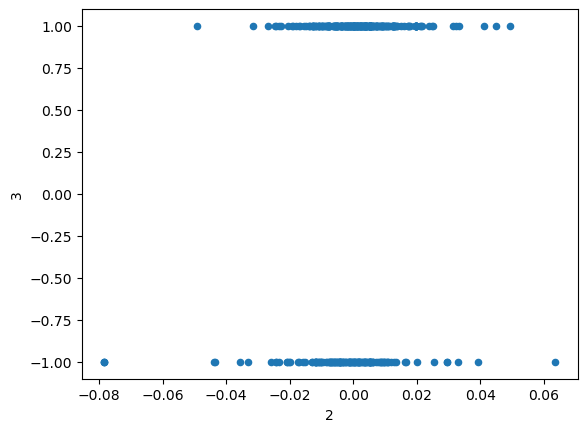

In [336]:
df[df[3]!=0.0].plot.scatter(x=2,y=3)

# Accuracy

In [304]:
df

,0,1,2,3,4,5,sign
0,0.025276,0.005140,0.020136,0.0,$VZ News Alert: http://t.co/c9msGPFgtc Updat...,VZ,1.0
1,0.016484,-0.003239,0.019723,1.0,$AGFS steady accumulation,AGFS,1.0
2,0.009303,0.000348,0.008955,1.0,The Boeing Company (NYSE:BA) Strikes Deal With...,BA,1.0
3,0.008763,0.006888,0.001875,0.0,Active Stocks Under Review: http://t.co/yRZS57...,DHR,1.0
4,0.005665,0.010563,-0.004898,-1.0,Your DOWN prediction for $MSFT on 2/10/2015 wa...,MSFT,-1.0
...,...,...,...,...,...,...,...
95,-0.005764,-0.013570,0.007806,-1.0,$TM:\n\nTM: China and Japan are Barriers for T...,TM,1.0
96,0.003676,0.004924,-0.001248,-1.0,$UPS Twinkies bankruptcy reveals trouble with ...,UPS,-1.0
97,0.006285,-0.001922,0.008207,1.0,$EXC still powering along...,EXC,1.0
98,0.010168,0.007168,0.003000,0.0,$CVX Find more winners like $HRS $HCN $SLV #ne...,CVX,1.0


In [337]:
tp = ((df[3]>0) & (df[2]>0)).sum()

In [338]:
tn = ((df[3]<0) & (df[2]<0)).sum()

In [339]:
fp = ((df[3]>0) & (df[2]<0)).sum()

In [340]:
fn = ((df[3]<0) & (df[2]>0)).sum()

In [341]:
(tp+tn)/(tp+tn+fp+fn)

0.5752427184466019

In [342]:
(tp*tn-fp*fn)

5504

In [343]:
((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))**0.5

40309.37955364731

In [344]:
(tp*tn-fp*fn)/((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))**0.5

0.1365439027081721

# Get S&P data

In [132]:
AAPL = pd.read_csv('data/stocknet/price/raw/AAPL.csv')

In [198]:
AAPL['Diff'] = (AAPL['Adj Close']-AAPL['Adj Close'].shift(1))/AAPL['Adj Close']

In [199]:
AAPL

,Date,Open,High,Low,Close,Adj Close,Volume,Diff
0,2012-09-04,95.108574,96.448570,94.928574,96.424286,87.121140,91973000,NaN
1,2012-09-05,96.510002,96.621429,95.657143,95.747147,86.509338,84093800,-0.007072
2,2012-09-06,96.167145,96.898575,95.828575,96.610001,87.288956,97799100,0.008931
3,2012-09-07,96.864288,97.497147,96.538574,97.205711,87.827171,82416600,0.006128
4,2012-09-10,97.207146,97.612854,94.585716,94.677139,85.542564,121999500,-0.026707
...,...,...,...,...,...,...,...,...
1253,2017-08-28,160.139999,162.000000,159.929993,161.470001,161.470001,25966000,0.009971
1254,2017-08-29,160.100006,163.119995,160.000000,162.910004,162.910004,29516900,0.008839
1255,2017-08-30,163.800003,163.889999,162.610001,163.350006,163.350006,27269600,0.002694
1256,2017-08-31,163.639999,164.520004,163.479996,164.000000,164.000000,26785100,0.003963


In [139]:
AAPL_ = pd.read_csv('data/stocknet/price/preprocessed/AAPL.txt', sep='\t', header=None)

In [140]:
AAPL_

,0,1,2,3,4,5,6
0,2017-09-01,0.000305,0.004878,0.005732,-0.002256,0.050003,16552800.0
1,2017-08-31,0.003979,0.001775,0.007163,0.000796,0.649994,26785100.0
2,2017-08-30,0.002701,0.005463,0.006016,-0.001842,0.440002,27269600.0
3,2017-08-29,0.008918,-0.008485,0.010219,-0.009104,1.440003,29516900.0
4,2017-08-28,0.010071,0.001752,0.013387,0.000438,1.610000,25966000.0
...,...,...,...,...,...,...,...
1252,2012-09-11,-0.003244,0.110742,0.119075,0.096363,-0.277496,125995800.0
1253,2012-09-10,-0.026013,0.106800,0.111420,0.076953,-2.284607,121999500.0
1254,2012-09-07,0.006166,0.109697,0.116947,0.105966,0.538215,82416600.0
1255,2012-09-06,0.009012,0.111639,0.120094,0.107725,0.779618,97799100.0


In [208]:
GSPC = yf.Ticker("^GSPC")

hist = GSPC.history(start="2012-01-01", end="2018-01-01")

hist['Diff'] = (hist['Close']-hist['Close'].shift(1))/hist['Close']

hist = hist.reset_index()

hist['Date'] = hist['Date'].dt.strftime('%Y-%m-%d')

hist = hist.set_index("Date")

hist.to_csv("data/stocknet/price/s&p.txt", sep='\t')

snp = hist